# Models

**In this notebook, we will proceed to compare models to find the best win probability model then build sub models to answer our research question: ** *Does the importance of a given event depend on the time left in the game?*

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
import seaborn.apionly as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib  import cm
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

In [19]:
# import scraped data
pbp = pd.read_csv("pbp.csv")
pbp = pbp.iloc[:,1:]

In [23]:
pbp.head()

,awayteam,hometeam,event,isawayevent,awayscore,homescore,quarter,gameID,isAssist,isOffRebound,...,isFT,isMade,isMissed,isTurnover,shotDistance,awayRun,awayLead,minutesRemaining,points_on_play,AWAY_WIN
0,Boston,Cleveland,Start of 1st quarter,1,2,0,1,0,0,0,...,0,0,0,0,0,0,2,48.000000,0,0
1,Boston,Cleveland,Jump ball: K. Love vs. A. Horford (K. Irving g...,1,2,0,1,0,0,0,...,0,0,0,0,0,0,2,48.000000,0,0
2,Boston,Cleveland,K. Irving makes 2-pt shot from 10 ft (assist b...,1,2,0,1,0,1,0,...,0,1,0,0,10,2,2,47.733333,2,0
3,Boston,Cleveland,D. Rose misses 2-pt shot from 1 ft (block by A...,0,2,0,1,0,0,0,...,0,0,1,0,1,2,2,47.450000,0,0
4,Boston,Cleveland,Defensive rebound by A. Horford,1,2,0,1,0,0,0,...,0,0,0,0,0,2,2,47.383333,0,0


In [60]:
# grab the relevant columns for model building
list1, list2 = list(pbp.columns[3:7]), list(pbp.columns[9:-1])
var = list1+list2
var

['isawayevent',
 'awayscore',
 'homescore',
 'quarter',
 'isOffRebound',
 'isDefRebound',
 'is3ptShot',
 'is2ptShot',
 'isFT',
 'isMade',
 'isMissed',
 'isTurnover',
 'shotDistance',
 'awayRun',
 'awayLead',
 'minutesRemaining',
 'points_on_play']

In [53]:
# Baseline Logistic Model

msk = np.random.rand(len(pbp)) < 0.3
data_train = pbp[msk]
data_test = pbp[~msk]

logit_model = LogisticRegression()
logit_model.fit(data_train[var],data_train.AWAY_WIN)

print("Logistic Regression Win Probability Model Train Accuracy: ", logit_model.score(data_train[var], data_train.AWAY_WIN))
print("\nLogistic Regression Win Probability Model Test Accuracy: ", logit_model.score(data_test[var], data_test.AWAY_WIN))

Logistic Regression Win Probability Model Train Accuracy:  0.738133751201

Logistic Regression Win Probability Model Test Accuracy:  0.735403820448


**These accuracies are quite good considering we are predicting on a play by play level of detail. In a game where lead changes and runs are common, the model is able to predict with over 70% accuracy. Our hypothesis is that the other 30% relates to occasions where the losing team does especially well during parts of the game.**

In [54]:
# prediction probabilities
pp = np.array(logit_model.predict_proba(pbp[var]))
# data for win probability viz
csvfile = {"gameID" : pbp.gameID, "min_rem" : pbp.minutesRemaining, "pp": pp[:,1], "away" : pbp.awayscore, 
           "home" : pbp.homescore, "run" : pbp.awayLead}
pd.DataFrame(csvfile).to_csv('LogitPP.csv')

In [55]:
#XGBoost Model

import xgboost as xgb
data_tot = xgb.DMatrix(pbp[var], label=pbp.AWAY_WIN)
dtrain = xgb.DMatrix(data_train[var], label=data_train.AWAY_WIN)
dtest = xgb.DMatrix(data_test[var], label=data_test.AWAY_WIN)
param = {'max_depth': 5, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist)

ypred = bst.predict(dtest)
predictions = [round(value) for value in ypred]
accuracy = accuracy_score(data_test.AWAY_WIN, predictions)
print("\nXGBoost Test Accuracy: %.2f%%" % (accuracy * 100.0))

ypred = bst.predict(dtrain)
predictions = [round(value) for value in ypred]
accuracy = accuracy_score(data_train.AWAY_WIN, predictions)
print("\nXGBoost Train Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	eval-auc:0.814617	train-auc:0.81752
[1]	eval-auc:0.817912	train-auc:0.821475
[2]	eval-auc:0.820351	train-auc:0.824788
[3]	eval-auc:0.822256	train-auc:0.827265
[4]	eval-auc:0.823528	train-auc:0.829802
[5]	eval-auc:0.826299	train-auc:0.834559
[6]	eval-auc:0.826615	train-auc:0.83642
[7]	eval-auc:0.826925	train-auc:0.838189
[8]	eval-auc:0.827964	train-auc:0.841476
[9]	eval-auc:0.829735	train-auc:0.844886

XGBoost Test Accuracy: 74.26%

XGBoost Train Accuracy: 75.52%


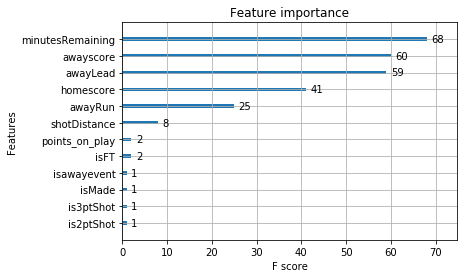

In [56]:
xgb.plot_importance(bst)